# Setup

In [1]:
import numpy as np
import pandas as pd 
import lightgbm as lgb
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve

/opt/conda/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(


# Data

In [2]:
train_df = pd.read_csv("/kaggle/input/playground-series-s4e1/train.csv")
original_df = pd.read_csv("/kaggle/input/bank-customer-churn-prediction/Churn_Modelling.csv")

# Functions and Parameters

In [3]:
def tidy_up_df(df):
    cols_to_drop = ["id", "CustomerId", "RowNumber"]
    cols_to_dummy = ["Geography", "Gender"]
    
    df = df.drop(columns=cols_to_drop, errors="ignore")

    for col in cols_to_dummy:
        if df[col].nunique() > 2:
            df = pd.get_dummies(df, columns=[col])
        else:
            df = pd.get_dummies(df, columns=[col], drop_first=True)
            
    return df

def create_submission_csv(submission_df, predictions):
    predictions_df = pd.DataFrame(ids)
    predictions_df["Exited"] = final_predictions[:, 1]
    
    submit_df = tidy_up_df(submission_df)
    ids = submit_df["id"]

# EDA

In [4]:
joined_df = pd.concat([train_df, original_df])
joined_df.drop(columns=["id", "RowNumber"], inplace=True)
joined_df

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9997,15584532,Liu,709,France,Female,36.0,7,0.00,1,0.0,1.0,42085.58,1
9998,15682355,Sabbatini,772,Germany,Male,42.0,3,75075.31,2,1.0,0.0,92888.52,1
9999,15682355,Sabbatini,772,Germany,Male,42.0,3,75075.31,2,1.0,0.0,92888.52,1
10000,15628319,Walker,792,France,Female,28.0,4,130142.79,1,1.0,0.0,38190.78,0


In [5]:
tidy_joined_df = tidy_up_df(joined_df)
tidy_joined_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 175036 entries, 0 to 10001
Data columns (total 14 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Surname            175036 non-null  object 
 1   CreditScore        175036 non-null  int64  
 2   Age                175035 non-null  float64
 3   Tenure             175036 non-null  int64  
 4   Balance            175036 non-null  float64
 5   NumOfProducts      175036 non-null  int64  
 6   HasCrCard          175035 non-null  float64
 7   IsActiveMember     175035 non-null  float64
 8   EstimatedSalary    175036 non-null  float64
 9   Exited             175036 non-null  int64  
 10  Geography_France   175036 non-null  bool   
 11  Geography_Germany  175036 non-null  bool   
 12  Geography_Spain    175036 non-null  bool   
 13  Gender_Male        175036 non-null  bool   
dtypes: bool(4), float64(5), int64(4), object(1)
memory usage: 15.4+ MB


In [6]:
tidy_joined_df[tidy_joined_df.isna().any(axis=1)]

,Surname,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_France,Geography_Germany,Geography_Spain,Gender_Male
4,Mitchell,850,43.0,2,125510.82,1,NaN,1.0,79084.10,0,False,False,True,False
8,He,501,44.0,4,142051.07,2,0.0,NaN,74940.50,0,True,False,False,True
9,H?,684,NaN,2,134603.88,1,1.0,1.0,71725.73,0,True,False,False,True


In [7]:
tidy_df = tidy_joined_df.dropna()
tidy_df = tidy_df[['Surname', 'CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Geography_France', 'Geography_Germany', 'Geography_Spain', 'Gender_Male', 'Exited']]
tidy_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 175033 entries, 0 to 10001
Data columns (total 14 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Surname            175033 non-null  object 
 1   CreditScore        175033 non-null  int64  
 2   Age                175033 non-null  float64
 3   Tenure             175033 non-null  int64  
 4   Balance            175033 non-null  float64
 5   NumOfProducts      175033 non-null  int64  
 6   HasCrCard          175033 non-null  float64
 7   IsActiveMember     175033 non-null  float64
 8   EstimatedSalary    175033 non-null  float64
 9   Geography_France   175033 non-null  bool   
 10  Geography_Germany  175033 non-null  bool   
 11  Geography_Spain    175033 non-null  bool   
 12  Gender_Male        175033 non-null  bool   
 13  Exited             175033 non-null  int64  
dtypes: bool(4), float64(5), int64(4), object(1)
memory usage: 15.4+ MB


## Trying some feature engineering to improve my model
- Using suggestions from [this post](https://www.kaggle.com/competitions/playground-series-s4e1/discussion/465192) I will try to band: 

1. Ages
2. Credit Score
3. Estiamted Salary 
4. Balance.

Based on findings [here](https://www.kaggle.com/competitions/playground-series-s4e1/discussion/467034https://www.kaggle.com/competitions/playground-series-s4e1/discussion/467034) I am going to include surname length as a feature.

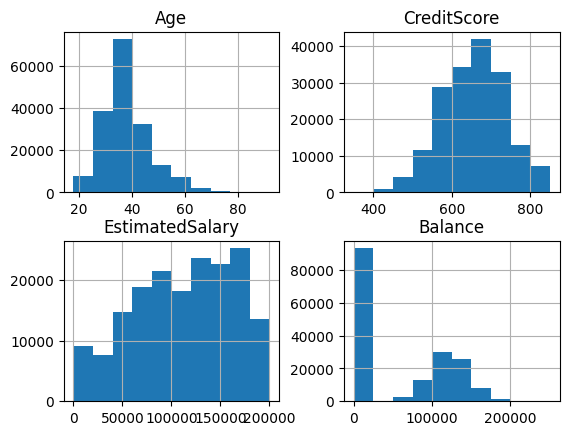

In [8]:
tidy_df[["Age", "CreditScore", "EstimatedSalary", "Balance"]].hist();

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


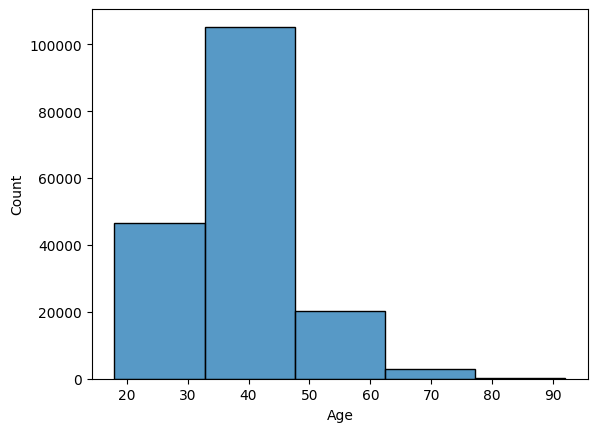

In [9]:
sns.histplot(tidy_df["Age"], bins=5)
plt.show();

In [10]:
age_labels = pd.cut(tidy_df["Age"].to_numpy(), bins=10, labels=False)
tidy_df["Age_Label"] = age_labels

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


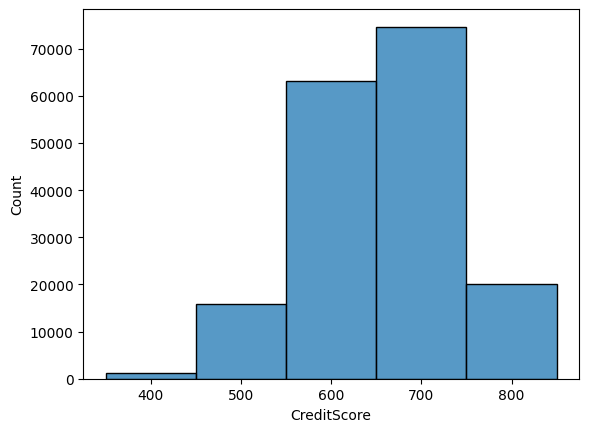

In [11]:
sns.histplot(tidy_df["CreditScore"], bins=5)
plt.show();

In [12]:
credit_lables = pd.cut(tidy_df["CreditScore"].to_numpy(), bins=5, labels=False)
tidy_df["Credit_Label"] = credit_lables

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


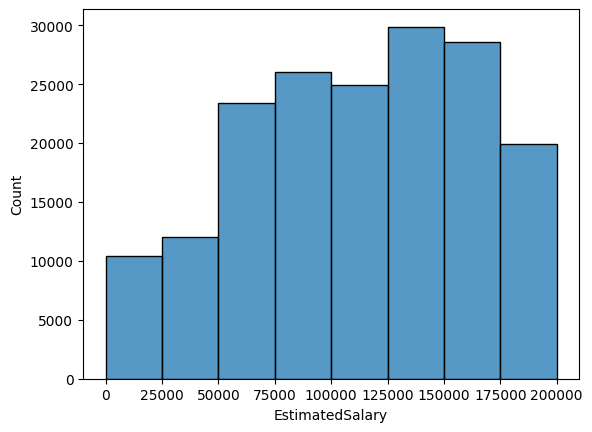

In [13]:
sns.histplot(tidy_df["EstimatedSalary"], bins=8)
plt.show();

In [14]:
salary_labels = pd.cut(tidy_df["EstimatedSalary"].to_numpy(), bins=8, labels=False)
tidy_df["Salary_Label"] = salary_labels

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


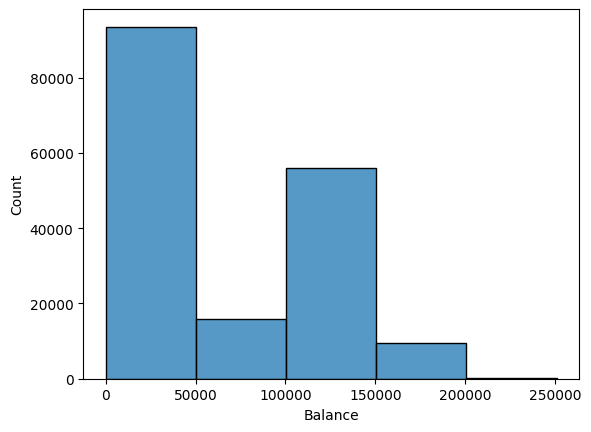

In [15]:
sns.histplot(tidy_df["Balance"], bins=5)
plt.show();

In [16]:
balance_labels = pd.cut(tidy_df["Balance"].to_numpy(), bins=5, labels=False)
tidy_df["Balance_Label"] = balance_labels

# Manipulate the Surnames

In [17]:
tidy_df["Surname_Length"] = tidy_df["Surname"].str.len()

In [18]:
tidy_df = tidy_df[['NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Geography_France', 'Geography_Germany', 'Geography_Spain', 'Gender_Male', 'Age_Label', 'Credit_Label', 'Salary_Label', 'Balance_Label', 'Surname_Length', 'Exited']]
tidy_df

,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Male,Age_Label,Credit_Label,Salary_Label,Balance_Label,Surname_Length,Exited
0,2,1.0,0.0,181449.97,True,False,False,True,2,3,7,0,14,0
1,2,1.0,1.0,49503.50,True,False,False,True,2,2,1,0,13,0
2,2,1.0,0.0,184866.69,True,False,False,True,2,3,7,0,5,0
3,1,1.0,1.0,84560.88,True,False,False,True,2,2,3,2,3,0
4,2,1.0,1.0,15068.83,False,False,True,True,2,3,0,0,9,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9997,1,0.0,1.0,42085.58,True,False,False,False,2,3,1,0,3,1
9998,2,1.0,0.0,92888.52,False,True,False,True,3,4,3,1,9,1
9999,2,1.0,0.0,92888.52,False,True,False,True,3,4,3,1,9,1
10000,1,1.0,0.0,38190.78,True,False,False,False,1,4,1,2,6,0


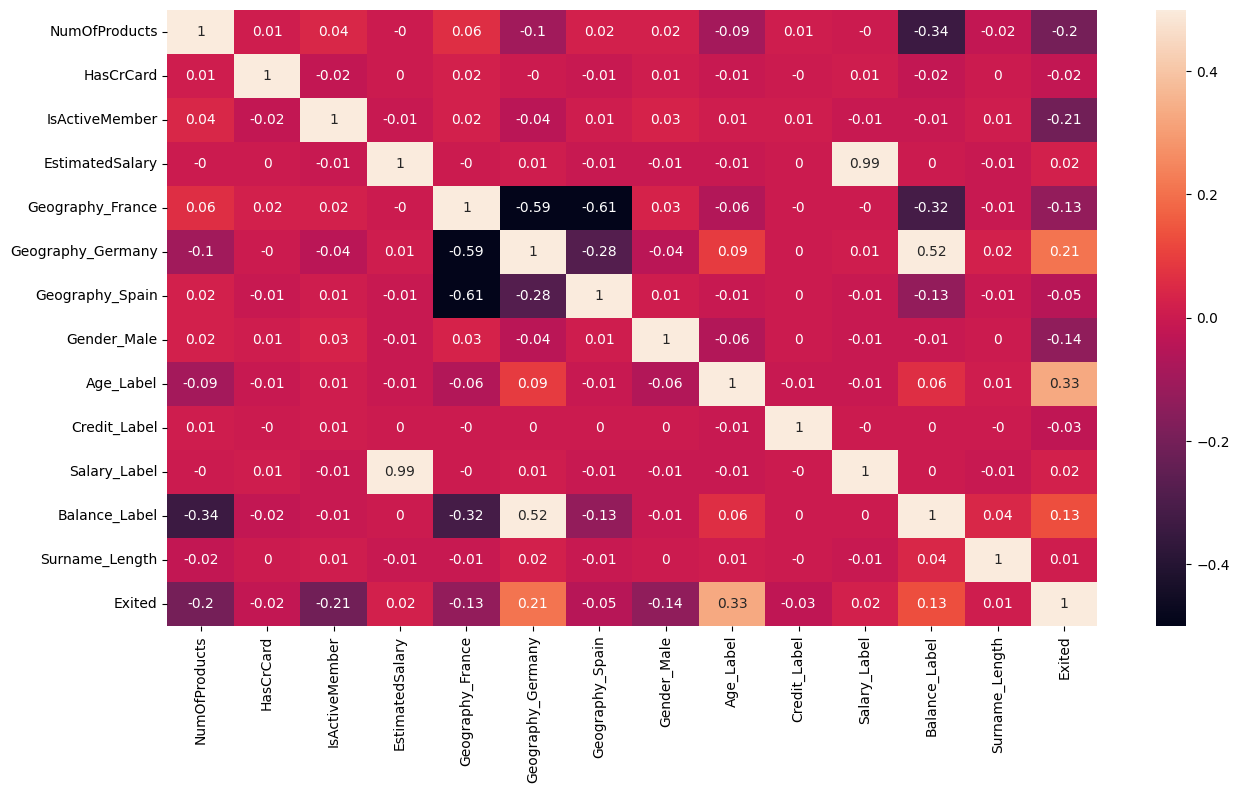

In [19]:
correlations = round(tidy_df.corr(), 2)
fig, ax = plt.subplots(figsize=(15,8))
sns.heatmap(correlations, annot=True, vmin=-0.5, vmax=0.5);

In [20]:
tidy_df_X = tidy_df.drop(columns="Exited")

In [21]:
tidy_df_Y = tidy_df["Exited"]
tidy_df_Y

0        0
1        0
2        0
3        0
4        0
        ..
9997     1
9998     1
9999     1
10000    0
10001    0
Name: Exited, Length: 175033, dtype: int64

# Model

In [22]:
train_X, test_X, train_Y, test_Y = train_test_split(tidy_df_X, tidy_df_Y, train_size=0.6, stratify=tidy_df_Y)

## Basic Model with defaults

In [23]:
basic_model = lgb.LGBMClassifier(device="GPU", gpu_platform_id=0, gpu_device_id=0)
basic_model.fit(train_X, train_Y)

[LightGBM] [Info] Number of positive: 22175, number of negative: 82844
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 105019, number of used features: 13
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...


1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.


[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 10 dense feature groups (1.20 MB) transferred to GPU in 0.003109 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211152 -> initscore=-1.317994
[LightGBM] [Info] Start training from score -1.317994


LGBMClassifier(device='GPU', gpu_device_id=0, gpu_platform_id=0)

In [24]:
basic_model.score(train_X, train_Y)

0.8670621506584523

In [25]:
predictions = basic_model.predict_proba(test_X)
roc_auc_score(test_Y, predictions[:, 1])

0.8832324246382502

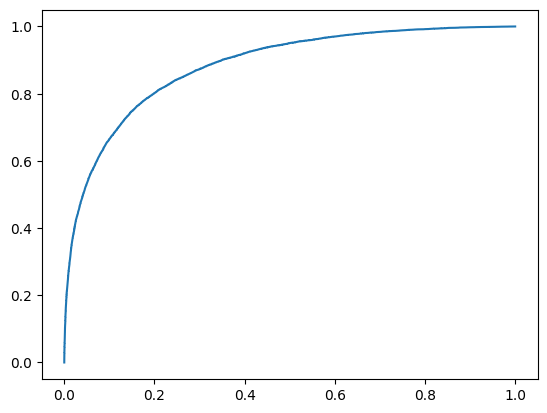

In [26]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(test_Y, predictions[:, 1])
plt.plot(false_positive_rate, true_positive_rate)
plt.show();

[LightGBM] [Info] Number of positive: 22175, number of negative: 82844
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 105019, number of used features: 13
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 10 dense feature groups (1.20 MB) transferred to GPU in 0.001888 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211152 -> initscore=-1.317994
[LightGBM] [Info] Start training from score -1.317994
0.8670621506584523
ROC AUC Score - 0.8832324662783653


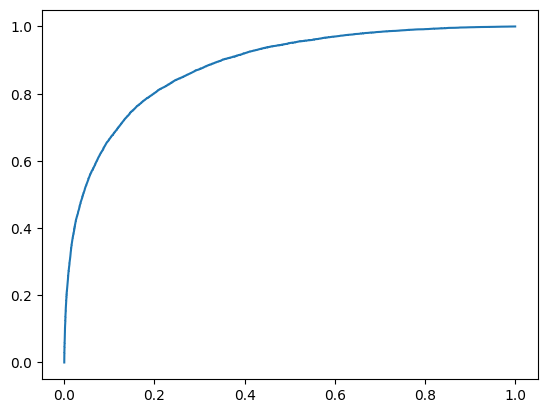

In [27]:
basic_model = lgb.LGBMClassifier(device="GPU", gpu_platform_id=0, gpu_device_id=0)
basic_model.fit(train_X, train_Y)
print(basic_model.score(train_X, train_Y))
predictions = basic_model.predict_proba(test_X)
print(f"ROC AUC Score - {roc_auc_score(test_Y, predictions[:, 1])}")
false_positive_rate, true_positive_rate, thresholds = roc_curve(test_Y, predictions[:, 1])
plt.plot(false_positive_rate, true_positive_rate)
plt.show();

## Improving the model

In [ ]:
param_dicts = [
    {"num_leaves" : tuple(np.arange(30,500,10))}
    , {"max_depth" : tuple(np.arange(-1,10,2))}
    , {"learning_rate" : (0.01, 0.05, 0.1, 0.2, 0.25)}
    , {"n_estimators" : tuple(np.arange(50,500,50))}
    , {"reg_alpha" : np.arange(0,0.8,0.05)}
    , {"reg_lambda" : np.arange(0,0.8,0.05)}
    , {"subsample" : np.arange(0.3,1.0,0.05)}
]

for param_dict in param_dicts:
    classifier = lgb.LGBMClassifier(device="GPU", gpu_platform_id=0, gpu_device_id=0)
    
    param_name = f"param_{list(param_dict.keys())[0]}"
    
    rvs_cv = RandomizedSearchCV(classifier, param_distributions=param_dict, scoring="roc_auc", n_jobs=-1, n_iter=100, verbose=1)
    rvs_cv.fit(train_X, train_Y)
    
    result_df = pd.DataFrame(rvs_cv.cv_results_)
    result_df.plot(kind="scatter", x=param_name, y="mean_test_score")

Fitting 5 folds for each of 47 candidates, totalling 235 fits


/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 47 is smaller than n_iter=100. Running 47 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserW

[LightGBM] [Info] Number of positive: 17740, number of negative: 66275
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 84015, number of used features: 13
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 10 dense feature groups (0.96 MB) transferred to GPU in 0.013340 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211153 -> initscore=-1.317991
[LightGBM] [Info] Start training from score -1.317991
[LightGBM] [Info] Number of positive: 17740, number of negative: 66275
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 84015, number of 

In [ ]:
params = {
    "num_leaves" : tuple(np.arange(30,100,10))
    , "max_depth" : tuple(np.arange(-1,10,2))
    , "learning_rate" : (0.05, 0.06, 0.07, 0.08, 0.09, 0.10)
    , "n_estimators" : tuple(np.arange(150, 200, 5))
    , "reg_alpha" : np.arange(0,0.2,0.02)
    , "reg_lambda" : np.arange(0,0.8,0.02)
    , "subsample" : np.arange(0.5,0.8,0.02)
}

classifier = lgb.LGBMClassifier(max_depth=-1, device="GPU", gpu_platform_id=0, gpu_device_id=0)
    
rvs_cv = RandomizedSearchCV(classifier, param_distributions=params, scoring="roc_auc", n_iter=100, n_jobs=-1, verbose=1)
rvs_cv.fit(train_X, train_Y)
    
result_df = pd.DataFrame(rvs_cv.cv_results_)

print(rvs_cv.best_params_)
print(rvs_cv.best_score_)
display(result_df)

In [ ]:
rvs_cv.best_score_

In [ ]:
rvs_cv.best_params_

In [ ]:
predictions = rvs_cv.predict_proba(test_X)
roc_auc_score(test_Y, predictions[:, 1])

# Stratified Cross Validation

In [ ]:
classifier = lgb.LGBMClassifier(
                device="GPU", gpu_platform_id=0, gpu_device_id=0, subsample = 0.32, 
                reg_lambda = 0.68, reg_alpha = 0.8000000000000002, num_leaves = 30, n_estimators = 130,
                learning_rate = 0.09
)

skf = StratifiedKFold(n_splits=5)
for split, (train, test) in enumerate(skf.split(tidy_df_X, tidy_df_Y)):
    print(f"--- Split Number {split} ---")
    train_X = tidy_df_X.iloc[train]
    train_Y = tidy_df_Y.iloc[train]
    
    classifier.fit(train_X, train_Y)

# Get Submission Predictions

In [ ]:
submit_df = pd.read_csv("/kaggle/input/playground-series-s4e1/test.csv")

In [ ]:
ids = submit_df["id"]
submit_df = pd.get_dummies(submit_df, columns=["Geography"])
submit_df = pd.get_dummies(submit_df, columns=["Gender"], drop_first=True)

age_labels = pd.cut(submit_df["Age"].to_numpy(), bins=10, labels=False)
submit_df["Age_Label"] = age_labels

credit_lables = pd.cut(submit_df["CreditScore"].to_numpy(), bins=5, labels=False)
submit_df["Credit_Label"] = credit_lables

salary_labels = pd.cut(submit_df["EstimatedSalary"].to_numpy(), bins=8, labels=False)
submit_df["Salary_Label"] = salary_labels

balance_labels = pd.cut(submit_df["Balance"].to_numpy(), bins=5, labels=False)
submit_df["Balance_Label"] = balance_labels

submit_df["Surname_Length"] = submit_df["Surname"].str.len()

submit_df = submit_df.drop(columns=["id", "CustomerId", "Surname", "Age", "CreditScore", "EstimatedSalary", "Balance"])
submit_df

In [ ]:
final_predictions = classifier.predict_proba(submit_df)
final_predictions[:, 1]

In [ ]:
submission_df = pd.DataFrame(ids)
submission_df["Exited"] = final_predictions[:, 1]

In [ ]:
submission_df.to_csv("submission.csv", index=False)